In [ ]:
%pip install pandas
%pip install numpy

In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [8]:
sessions_path = 'content/sessions.jsonl'

sessions = pd.read_json(sessions_path, lines=True, encoding='utf-8')


tracks_path = 'content/tracks.jsonl'

tracks = pd.read_json(tracks_path, lines=True, encoding='utf-8')



users_path = 'content/users.jsonl'

users = pd.read_json(users_path, lines=True, encoding='utf-8')


artists_path = 'content/artists.jsonl'

artists = pd.read_json(artists_path, lines=True, encoding='utf-8')


In [9]:
print(f'sessions: {sessions.columns}')
print(f'tracks: {tracks.columns}')
print(f'users: {users.columns}')
print(f'artists: {artists.columns}')


sessions: Index(['timestamp', 'user_id', 'track_id', 'event_type', 'session_id'], dtype='object')
tracks: Index(['id', 'artist_id', 'name', 'popularity', 'duration_ms', 'explicit',
       'release_date', 'danceability', 'energy', 'key', 'mode', 'loudness',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'time_signature'],
      dtype='object')
users: Index(['user_id', 'name', 'city', 'street', 'favourite_genres',
       'premium_user'],
      dtype='object')
artists: Index(['id', 'name', 'genres'], dtype='object')


In [11]:
sessions['timestamp'] = pd.to_datetime(sessions['timestamp'])
sessions['date'] = sessions['timestamp'].dt.strftime('%Y-%m-%d')
sessions['month'] = sessions['timestamp'].dt.strftime('%Y-%m')

In [12]:
# sessions: Index(['timestamp', 'user_id', 'track_id', 'event_type', 'session_id'], dtype='object')
track_id_duration = dict(zip(tracks['id'], tracks['duration_ms']))
# Map values to a new column using a dictionary
sessions['track_len'] = sessions['track_id'].map(track_id_duration)
sessions['duration_ms'] = 0
# [conditions, what to modify] = new value for selected by condtions columns to modify
sessions.loc[sessions['event_type'] == "Play", 'duration_ms'] = sessions['track_len']
# @TODO see time between play and skip and in the duration ms put - only the time that the song was plahyed
sessions.loc[sessions['event_type'] == "Skip", 'duration_ms'] = -sessions['track_len']

In [13]:
sessions['song_played_in_full'] = sessions['event_type'].map({"Play":1,"Skip":-1}).fillna(0)


In [14]:
sessions['song_liked'] = sessions['event_type'].map({"Like":1}).fillna(0)
sessions['Advertisment_played'] = sessions['event_type'].map({"Advertisement":1}).fillna(0)

Definicja tych atrbutów:
- x Ilość wysłuchanych piosenek
- Średnia ilość wysłuchanych piosenek w sesji,dniu
- Ilość sesji
- Skip rate na sesje,dzień
- x Czas słuchania full
- średni czas słuchania dzienny
- Czas słuchania w jednej sesji
- Ilość polubionych piosenek na wysłuchane


In [16]:
# total time user listened
duration_played_ms = sessions.groupby("user_id")['duration_ms'].sum().reset_index()
users = pd.merge(users, duration_played_ms, on='user_id', how='left', suffixes=('', '_total'))
users.rename(columns={'duration_ms': 'total_time_songs_played_ms'}, inplace=True)

In [17]:
# ototal number of songs played
count_of_songs_played_in_full = sessions.groupby("user_id")["song_played_in_full"].sum().reset_index()
users = pd.merge(users, count_of_songs_played_in_full, on='user_id', how='left', suffixes=('', '_total'))
users.rename(columns={'song_played_in_full': 'nr_song_played_in_full'}, inplace=True)


In [ ]:
# Number of songs played average day
df = sessions.groupby(["user_id", 'date'])["song_played_in_full"].sum().reset_index()
df.head()
df = df.groupby(["user_id"])["song_played_in_full"].mean().reset_index()
df.rename(columns={'song_played_in_full': 'avg_nr_songs_played_per_day'}, inplace=True)
users = pd.merge(users, df, on='user_id', how='left', suffixes=('', '_total'))

,user_id,name,city,street,favourite_genres,premium_user,total_time_songs_played_ms,nr_song_played_in_full,avg_nr_songs_played_per_day
0,101,Jerzy Tatarczyk,Wyszków,Błękitna 928,"[lounge, rock, motown]",False,31590809,152.0,19.000000
1,102,Rozalia Kujda,Konin,Polna 670,"[mellow gold, permanent wave, latin rock]",False,16904227,71.0,10.142857
2,103,Kazimierz Posłuszna,Żagań,Tęczowa 883,"[pop, ranchera, blues rock]",False,39829642,202.0,18.363636


In [19]:
users.describe()

,user_id,total_time_songs_played_ms,nr_song_played_in_full,avg_nr_songs_played_per_day
count,3000.000000,3.000000e+03,3000.000000,3000.000000
mean,1600.500000,4.333224e+07,198.489333,15.188397
std,866.169729,2.108558e+07,104.305288,5.591425
min,101.000000,6.764083e+06,27.000000,4.500000
25%,850.750000,2.692320e+07,117.000000,10.000000
50%,1600.500000,3.981109e+07,175.000000,14.612500
75%,2350.250000,5.589680e+07,264.000000,20.142857
max,3100.000000,1.072634e+08,515.000000,34.166667


In [ ]:
# Number of songs played average session
df = sessions.groupby(["user_id", 'session_id'])["song_played_in_full"].sum().reset_index()
df.head()
df = df.groupby(["user_id"])["song_played_in_full"].mean().reset_index()
df.rename(columns={'song_played_in_full': 'avg_nr_songs_played_per_session'}, inplace=True)
df.describe()

users = pd.merge(users, df, on='user_id', how='left', suffixes=('', '_total'))

,user_id,name,city,street,favourite_genres,premium_user,total_time_songs_played_ms,nr_song_played_in_full,avg_nr_songs_played_per_day,avg_nr_songs_played_per_session
0,101,Jerzy Tatarczyk,Wyszków,Błękitna 928,"[lounge, rock, motown]",False,31590809,152.0,19.000000,19.000000
1,102,Rozalia Kujda,Konin,Polna 670,"[mellow gold, permanent wave, latin rock]",False,16904227,71.0,10.142857,10.142857
2,103,Kazimierz Posłuszna,Żagań,Tęczowa 883,"[pop, ranchera, blues rock]",False,39829642,202.0,18.363636,18.363636


In [ ]:
# length of songs played average session 
df = sessions.groupby(["user_id", 'session_id'])["duration_ms"].sum().reset_index()
df.head()
df = df.groupby(["user_id"])["duration_ms"].mean().reset_index()
df.rename(columns={'duration_ms': 'avg_time_playing_by_session'}, inplace=True)
df.describe()
users = pd.merge(users, df, on='user_id', how='left', suffixes=('', '_total'))

,user_id,name,city,street,favourite_genres,premium_user,total_time_songs_played_ms,nr_song_played_in_full,avg_nr_songs_played_per_day,avg_nr_songs_played_per_session,avg_time_playing_by_session
0,101,Jerzy Tatarczyk,Wyszków,Błękitna 928,"[lounge, rock, motown]",False,31590809,152.0,19.000000,19.000000,3.948851e+06
1,102,Rozalia Kujda,Konin,Polna 670,"[mellow gold, permanent wave, latin rock]",False,16904227,71.0,10.142857,10.142857,2.414890e+06
2,103,Kazimierz Posłuszna,Żagań,Tęczowa 883,"[pop, ranchera, blues rock]",False,39829642,202.0,18.363636,18.363636,3.620877e+06


In [ ]:
# length of songs played average  day
df = sessions.groupby(["user_id", 'date'])["duration_ms"].sum().reset_index()
df.head()
df = df.groupby(["user_id"])["duration_ms"].mean().reset_index()
df.rename(columns={'duration_ms': 'avg_time_playing_in_a_day'}, inplace=True)
df.describe()
users = pd.merge(users, df, on='user_id', how='left', suffixes=('', '_total'))

,user_id,name,city,street,favourite_genres,premium_user,total_time_songs_played_ms,nr_song_played_in_full,avg_nr_songs_played_per_day,avg_nr_songs_played_per_session,avg_time_playing_by_session,avg_time_playing_in_a_day
0,101,Jerzy Tatarczyk,Wyszków,Błękitna 928,"[lounge, rock, motown]",False,31590809,152.0,19.000000,19.000000,3.948851e+06,3.948851e+06
1,102,Rozalia Kujda,Konin,Polna 670,"[mellow gold, permanent wave, latin rock]",False,16904227,71.0,10.142857,10.142857,2.414890e+06,2.414890e+06
2,103,Kazimierz Posłuszna,Żagań,Tęczowa 883,"[pop, ranchera, blues rock]",False,39829642,202.0,18.363636,18.363636,3.620877e+06,3.620877e+06


In [ ]:
# number of unique songs played
df = sessions.groupby(["user_id", 'track_id'])["song_played_in_full"].sum().reset_index()
df["was_song_played"] = 0
df.loc[df["song_played_in_full"] > 0, 'was_song_played'] = 1
df = df.groupby(["user_id"])["was_song_played"].count().reset_index()
df.rename(columns={'was_song_played': 'number_of_unique_songs_listened_through'}, inplace=True)
users = pd.merge(users, df, on='user_id', how='left', suffixes=('', '_total'))

,user_id,name,city,street,favourite_genres,premium_user,total_time_songs_played_ms,nr_song_played_in_full,avg_nr_songs_played_per_day,avg_nr_songs_played_per_session,avg_time_playing_by_session,avg_time_playing_in_a_day,number_of_unique_songs_listened_through
0,101,Jerzy Tatarczyk,Wyszków,Błękitna 928,"[lounge, rock, motown]",False,31590809,152.0,19.000000,19.000000,3.948851e+06,3.948851e+06,146
1,102,Rozalia Kujda,Konin,Polna 670,"[mellow gold, permanent wave, latin rock]",False,16904227,71.0,10.142857,10.142857,2.414890e+06,2.414890e+06,142
2,103,Kazimierz Posłuszna,Żagań,Tęczowa 883,"[pop, ranchera, blues rock]",False,39829642,202.0,18.363636,18.363636,3.620877e+06,3.620877e+06,200


In [ ]:
# number of songs liked and advertisments heard
df = sessions.groupby(["user_id"])["song_liked"].sum().reset_index()
df.rename(columns={'song_liked': 'nr_of_songs_liked'}, inplace=True)
users = pd.merge(users, df, on='user_id', how='left', suffixes=('', '_total'))

,user_id,name,city,street,favourite_genres,premium_user,total_time_songs_played_ms,nr_song_played_in_full,avg_nr_songs_played_per_day,avg_nr_songs_played_per_session,avg_time_playing_by_session,avg_time_playing_in_a_day,number_of_unique_songs_listened_through,nr_of_songs_liked
0,101,Jerzy Tatarczyk,Wyszków,Błękitna 928,"[lounge, rock, motown]",False,31590809,152.0,19.000000,19.000000,3.948851e+06,3.948851e+06,146,10.0
1,102,Rozalia Kujda,Konin,Polna 670,"[mellow gold, permanent wave, latin rock]",False,16904227,71.0,10.142857,10.142857,2.414890e+06,2.414890e+06,142,46.0
2,103,Kazimierz Posłuszna,Żagań,Tęczowa 883,"[pop, ranchera, blues rock]",False,39829642,202.0,18.363636,18.363636,3.620877e+06,3.620877e+06,200,15.0


In [ ]:
# number of advertisments heard
df = sessions.groupby(["user_id"])["Advertisment_played"].sum().reset_index()
df.rename(columns={'Advertisment_played': 'nr_of_ads_heard'}, inplace=True)
users = pd.merge(users, df, on='user_id', how='left', suffixes=('', '_total'))

,user_id,name,city,street,favourite_genres,premium_user,total_time_songs_played_ms,nr_song_played_in_full,avg_nr_songs_played_per_day,avg_nr_songs_played_per_session,avg_time_playing_by_session,avg_time_playing_in_a_day,number_of_unique_songs_listened_through,nr_of_songs_liked,nr_of_ads_heard
0,101,Jerzy Tatarczyk,Wyszków,Błękitna 928,"[lounge, rock, motown]",False,31590809,152.0,19.000000,19.000000,3.948851e+06,3.948851e+06,146,10.0,38.0
1,102,Rozalia Kujda,Konin,Polna 670,"[mellow gold, permanent wave, latin rock]",False,16904227,71.0,10.142857,10.142857,2.414890e+06,2.414890e+06,142,46.0,43.0
2,103,Kazimierz Posłuszna,Żagań,Tęczowa 883,"[pop, ranchera, blues rock]",False,39829642,202.0,18.363636,18.363636,3.620877e+06,3.620877e+06,200,15.0,53.0


In [26]:
# Number of ads heard per day day
df = sessions.groupby(["user_id", 'date'])["Advertisment_played"].sum().reset_index()
df.head()
df = df.groupby(["user_id"])["Advertisment_played"].mean().reset_index()
df.rename(columns={'Advertisment_played': 'nr_of_ads_heard_per_day'}, inplace=True)
users = pd.merge(users, df, on='user_id', how='left', suffixes=('', '_total'))

df = sessions.groupby(["user_id", 'date'])["song_liked"].sum().reset_index()
df.head()
df = df.groupby(["user_id"])["song_liked"].mean().reset_index()
df.rename(columns={'song_liked': 'nr_of_songs_liked_per_day'}, inplace=True)
users = pd.merge(users, df, on='user_id', how='left', suffixes=('', '_total'))

users.head(3)

,user_id,name,city,street,favourite_genres,premium_user,total_time_songs_played_ms,nr_song_played_in_full,avg_nr_songs_played_per_day,avg_nr_songs_played_per_session,avg_time_playing_by_session,avg_time_playing_in_a_day,number_of_unique_songs_listened_through,nr_of_songs_liked,nr_of_ads_heard,nr_of_ads_heard_per_day,nr_of_songs_liked_per_day
0,101,Jerzy Tatarczyk,Wyszków,Błękitna 928,"[lounge, rock, motown]",False,31590809,152.0,19.000000,19.000000,3.948851e+06,3.948851e+06,146,10.0,38.0,4.750000,1.250000
1,102,Rozalia Kujda,Konin,Polna 670,"[mellow gold, permanent wave, latin rock]",False,16904227,71.0,10.142857,10.142857,2.414890e+06,2.414890e+06,142,46.0,43.0,6.142857,6.571429
2,103,Kazimierz Posłuszna,Żagań,Tęczowa 883,"[pop, ranchera, blues rock]",False,39829642,202.0,18.363636,18.363636,3.620877e+06,3.620877e+06,200,15.0,53.0,4.818182,1.363636


In [ ]:
users["is_premium"] = users["premium_user"].map({True:1,False:0})

# Analiza wygenerowanych atrybutów

In [38]:
X = users[[
    # 'user_id', 
# 'name', 'city', 'street', 'favourite_genres', 'premium_user',
       'total_time_songs_played_ms', 'nr_song_played_in_full',
       'avg_nr_songs_played_per_day', 'avg_nr_songs_played_per_session',
       'avg_time_playing_by_session', 'avg_time_playing_in_a_day',
       'number_of_unique_songs_listened_through', 'nr_of_songs_liked',
       'nr_of_ads_heard', 'nr_of_ads_heard_per_day',
       'nr_of_songs_liked_per_day', 
    #    'is_premium'
       ]]

Y = users[[
    # 'user_id', 
# 'name', 'city', 'street', 'favourite_genres', 'premium_user',
    #    'total_time_songs_played_ms', 'nr_song_played_in_full',
    #    'avg_nr_songs_played_per_day', 'avg_nr_songs_played_per_session',
    #    'avg_time_playing_by_session', 'avg_time_playing_in_a_day',
    #    'number_of_unique_songs_listened_through', 'nr_of_songs_liked',
    #    'nr_of_ads_heard', 'nr_of_ads_heard_per_day',
    #    'nr_of_songs_liked_per_day', 
       'is_premium'
       ]]

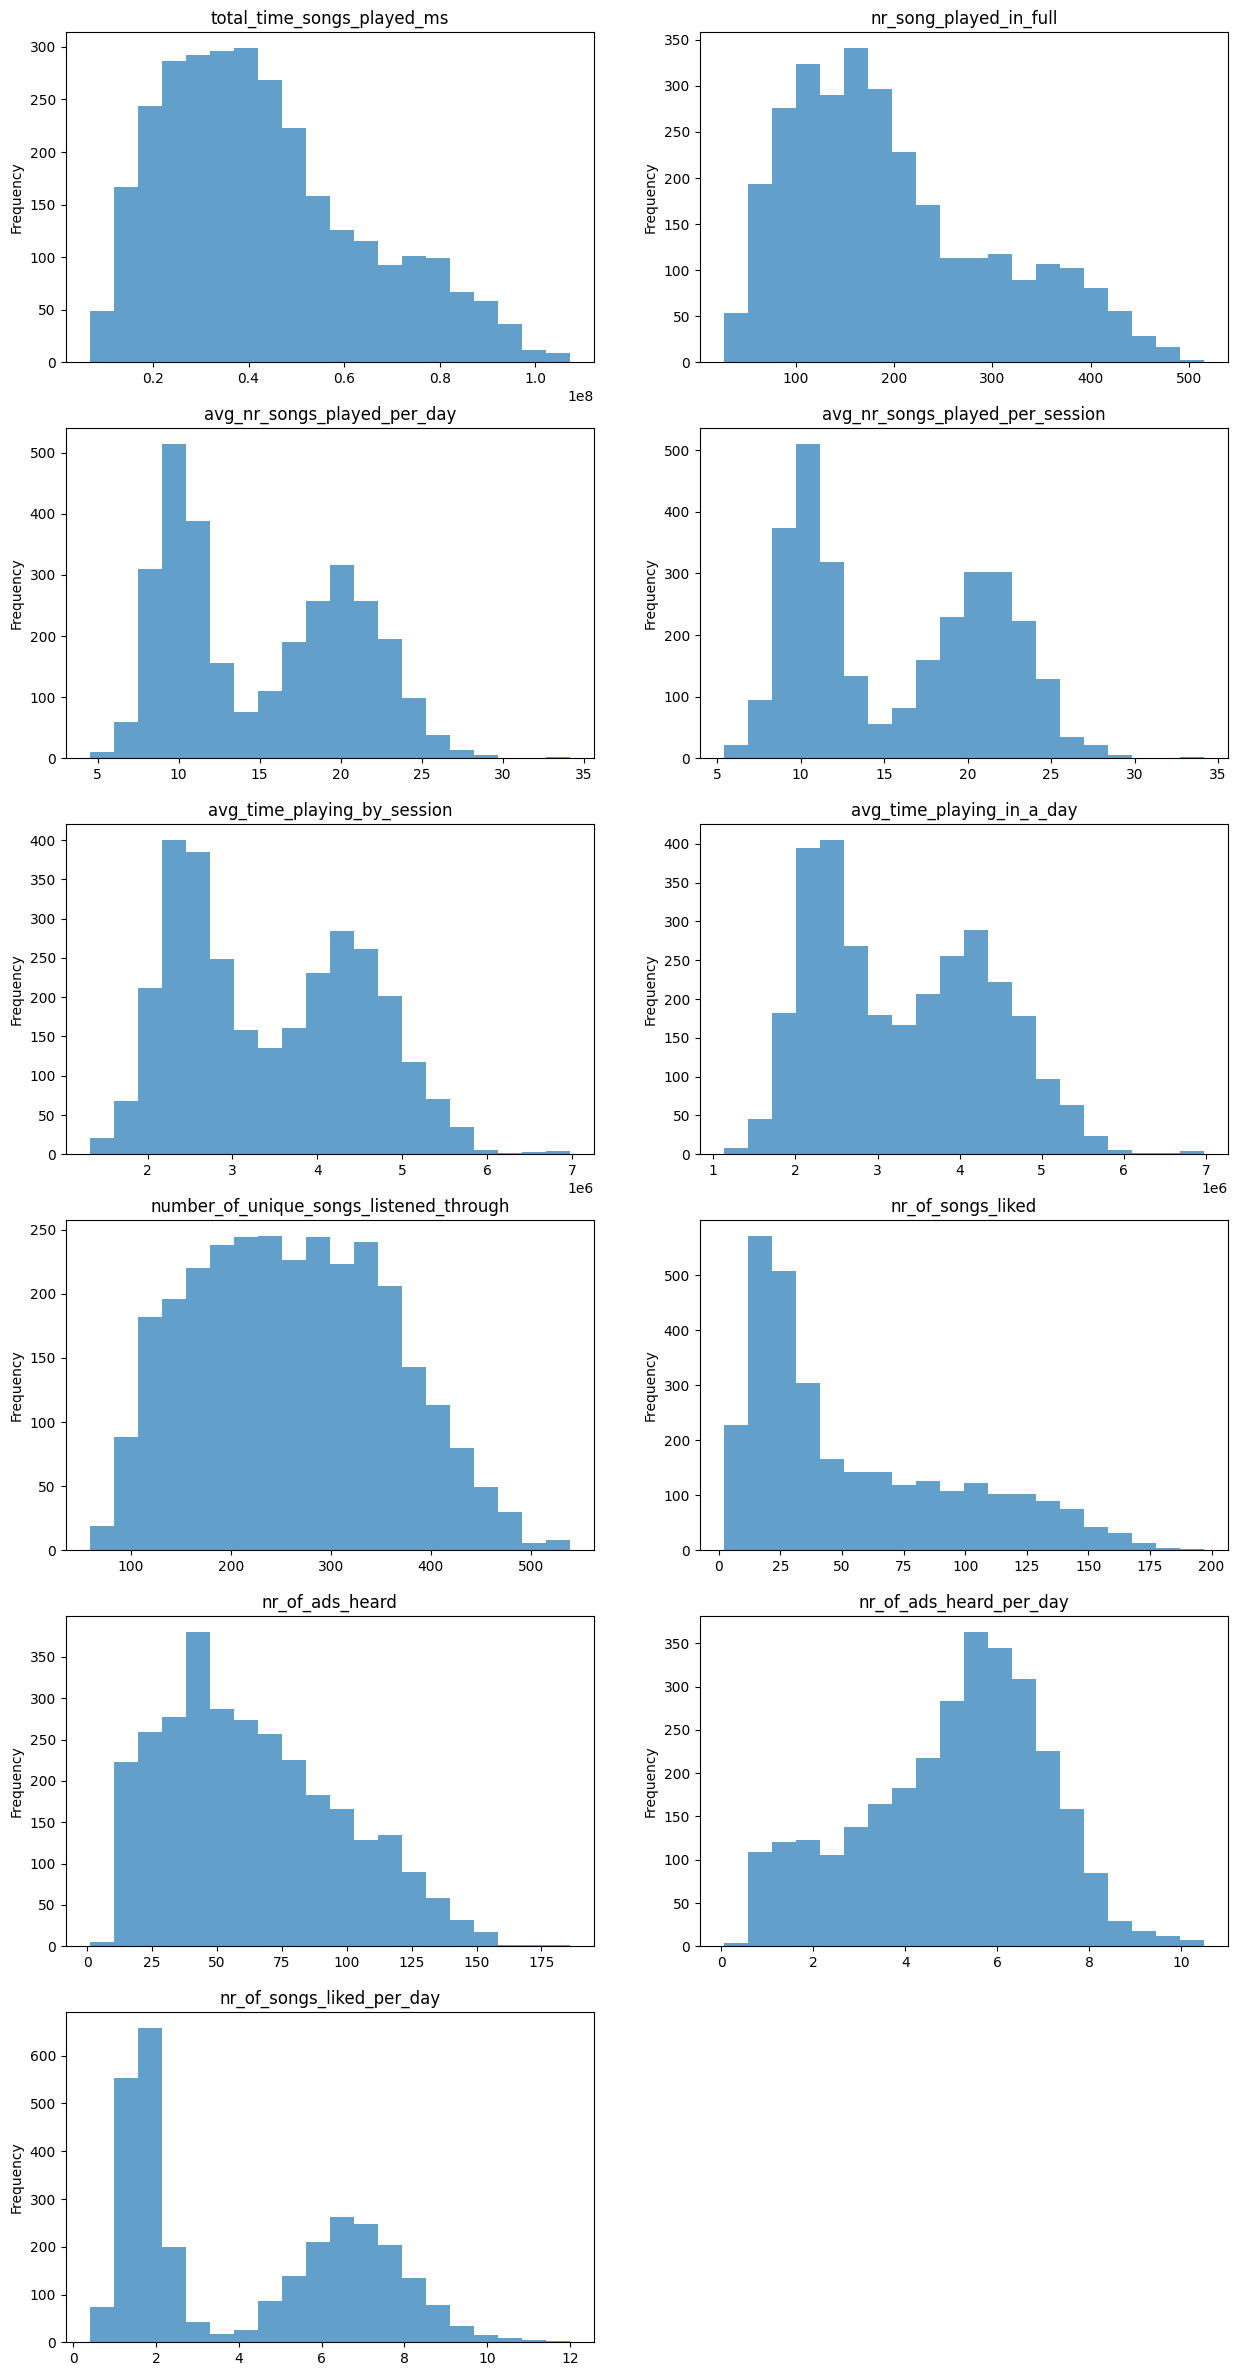

In [49]:

n_attributes = len(X.keys())

n_cols = 2  
n_rows = (n_attributes // n_cols) + (n_attributes % n_cols > 0)  

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))

axes = axes.flatten()

for idx, (x, ax) in enumerate(zip(X.keys(), axes)):
    X[x].plot(kind="hist", bins=20, alpha=0.7, ax=ax)
    ax.set_title(f"{x}")
    # ax.set_xlabel(x) 
    ax.set_ylabel('Frequency')  

for idx in range(n_attributes, len(axes)):
    axes[idx].axis('off')

plt.show()
